## Smoking model

In [ ]:
import numpy as np

# ---------------------
# 1. MODEL PARAMETERS
# ---------------------
T = 50                # Number of periods
delta_S = 0.1         # Depreciation factor for S
y = 10                # Income (or similar constant)
p = 7                 # Price or cost parameter for smoking

# Parameters for the utility function
a_sigma  = -0.5      # Increased weight on sigma effects (disease status)
a_0      = 0.1
a_c      = 0.6
a_sb     = 0.4
a_bsigma = -0.5
beta     = 0.99       # Increase discount factor so future matters more

# ---------------------
# 2. GRIDS
# ---------------------
# Grid for S (continuous, positive)
S_grid = np.linspace(0.1, 50, 50)
nS = len(S_grid)

# Grid for sigma (binary)
sigma_values = [0, 1]
nSigma = len(sigma_values)

# Grid for lambda (beliefs)
lambda_grid = np.linspace(-20, 20, 50)
nLambda = len(lambda_grid)

# ---------------------
# 3. CHOICE SET
# ---------------------
b_choices = [0, 1]  # e.g. 0 = no smoking, 1 = smoking

# -----------------

In [ ]:
----
# 4. UTILITY FUNCTION
# ---------------------
def utility(S, sigma, b):
    """
    Example utility function.
    """
    return np.exp(a_sigma * sigma) * (a_0 + (y - p * b)**a_c * (1 + S * b)**a_sb * (1 + sigma * b)**a_bsigma)

# ---------------------
# 5. TRANSITION FUNCTIONS
# ---------------------
def transition_S(S, b):
    """
    Transition for S: S evolves depending on b.
    """
    if b == 1:
        new_S = (1 - delta_S) * S + 1
    else:
        new_S = (1 - delta_S) * S
    # Keep S within grid bounds.
    new_S = max(new_S, S_grid[0])
    new_S = min(new_S, S_grid[-1])
    return new_S

def pi_of_S(S, k=0.2, S0=50):
    """
    A logistic function that maps S to (0,1) such that:
      - If S << S0, then pi(S) is near 0.
      - If S >> S0, then pi(S) is near 1.
      
    Parameters:
      k: controls the steepness of the curve.
      S0: the value of S at which pi(S)=0.5.
    """
    return 1.0 / (1.0 + np.exp(-k * (S - S0)))


def transition_lambda(lambda_val, S, sigma_lagged, sigma_current):
    """
    Update beliefs lambda according to:
      if sigma_lagged == 0:
          if sigma_current == 1:
              lambda_new = lambda + log(pi(S)/pi(0))
          else:
              lambda_new = lambda + log((1-pi(S))/(1-pi(0)))
      else:
          lambda_new = lambda
    """
    if sigma_lagged == 0:
        if sigma_current == 1:
            new_lambda = lambda_val + np.log(pi_of_S(S) / pi_of_S(0))
        else:
            new_lambda = lambda_val + np.log((1 - pi_of_S(S)) / (1 - pi_of_S(0)))
    else:
        new_lambda = lambda_val
    return new_lambda

def prob_sigma_next_is_one(sigma_current, lambda_val, S):
    """
    Returns the probability that sigma_{t+1} = 1.
    For sigma_current=1, assume sigma remains 1.
    For sigma_current=0, use a logistic-based formula incorporating lambda.
    """
    if sigma_current == 1:
        return 1.0
    else:
        # Example formulation: 
        # P(sigma_{t+1}=1 | sigma_t=0, lambda, S) = [pi(S)*exp(lambda) + pi(0)] / [1+exp(lambda)]
        num = pi_of_S(S) * np.exp(lambda_val) + pi_of_S(0)
        den = 1.0 + np.exp(lambda_val)
        output = num / den
        assert output <= 1 and output >=0, "det er ikke en sandsynlighed"
        return output

# ---------------------
# 6. VALUE FUNCTION & POLICY ARRAYS
# ---------------------
# Four-dimensional arrays: dimensions (T, nS, nSigma, nLambda)
V_og = np.zeros((T, nS, nSigma, nLambda))
Policy_og = np.zeros((T, nS, nSigma, nLambda), dtype=int)

# ---------------------
# 7. BACKWARD INDUCTION
# ---------------------
# --- Last Period (t = T-1): Agent maximizes immediate utility ---
t = T - 1
for i, S_val in enumerate(S_grid):
    for j, sigma_val in enumerate(sigma_values):
        for k, lambda_val in enumerate(lambda_grid):
            best_value = -np.inf
            best_choice = 0
            for b in b_choices:
                u = utility(S_val, sigma_val, b)
                if u > best_value:
                    best_value = u
                    best_choice = b
            V_og[t, i, j, k] = best_value
            Policy_og[t, i, j, k] = best_choice

# --- Earlier Periods: t = T-2 down to 0 ---
for t in reversed(range(T - 1)):
    for i, S_val in enumerate(S_grid):
        for j, sigma_val in enumerate(sigma_values):
            for k, lambda_val in enumerate(lambda_grid):
                best_value = -np.inf
                best_choice = 0
                for b in b_choices:
                    # Immediate utility
                    u = utility(S_val, sigma_val, b)
                    
                    # Next state for S (deterministic)
                    S_next = transition_S(S_val, b)
                    i_next = np.argmin(np.abs(S_grid - S_next))
                    
                    # Probability that sigma_{t+1}=1 (if current sigma==0)
                    p1 = prob_sigma_next_is_one(sigma_val, lambda_val, S_val)
                    
                    # Determine lambda transition for both possible sigma outcomes.
                    # For sigma_{t+1} = 1:
                    lambda_next_1 = transition_lambda(lambda_val, S_val, sigma_val, 1)
                    k_next_1 = np.argmin(np.abs(lambda_grid - lambda_next_1))
                    # For sigma_{t+1} = 0:
                    lambda_next_0 = transition_lambda(lambda_val, S_val, sigma_val, 0)
                    k_next_0 = np.argmin(np.abs(lambda_grid - lambda_next_0))
                    
                    # Next sigma: if sigma already 1, remains 1; if 0, can be 1 with probability p1, 0 with 1-p1.
                    # For sigma_{t+1}=1, we assign j_next_1 = 1, and for sigma_{t+1}=0, j_next_0 = 0.
                    j_next_1 = 1
                    j_next_0 = 0
                    
                    # Expected continuation value.
                    cont_val = (p1 * V_og[t+1, i_next, j_next_1, k_next_1] +
                                (1 - p1) * V_og[t+1, i_next, j_next_0, k_next_0])
                    
                    total_value = u + beta * cont_val
                    # print(f'b: {b} and t: {t} and lambda: {k} we have that total value is {total_value}')
                    if total_value > best_value:
                        best_value = total_value
                        best_choice = b

                V_og[t, i, j, k] = best_value
                Policy_og[t, i, j, k] = best_choice

# ---------------------
# 8. EXAMPLE USAGE
# ---------------------
# Retrieve the optimal decision and value at time t=0 for a given state:
t0 = 0
S_example = 0.0
sigma_example = 0
lambda_example = -0.0

# Find the nearest indices in the grids
i_example = np.argmin(np.abs(S_grid - S_example))
j_example = sigma_values.index(sigma_example)
k_example = np.argmin(np.abs(lambda_grid - lambda_example))

optimal_decision = Policy_og[t0, i_example, j_example, k_example]
optimal_value    = V_og[t0, i_example, j_example, k_example]

print(f"At t={t0}, S={S_example:.2f}, sigma={sigma_example}, lambda={lambda_example:.2f}:")
print(f"  Optimal decision b = {optimal_decision}")
print(f"  Value function     = {optimal_value:.4f}")


At t=0, S=0.00, sigma=0, lambda=-0.00:
  Optimal decision b = 0
  Value function     = 161.1348


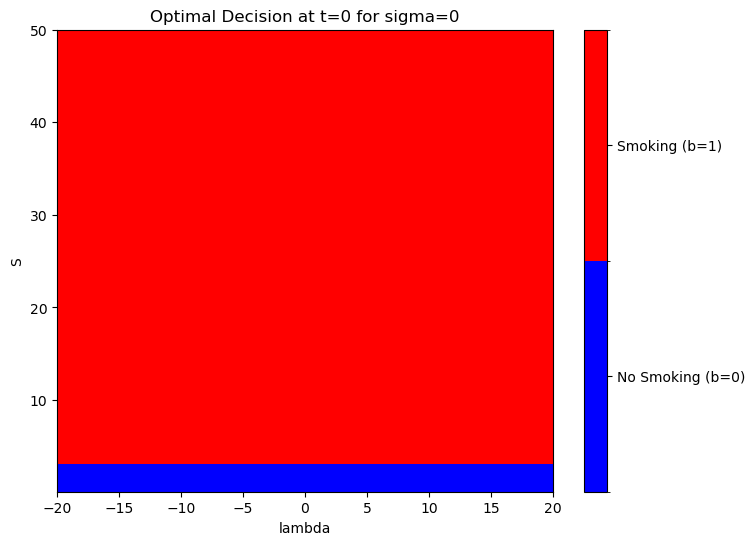

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Assuming Policy, S_grid, lambda_grid, and sigma_values are defined from the previous code.
# Here, t0=0 and we consider sigma=0.
t0 = 1
sigma0_index = 0

# Create a 2D array to store the optimal decision for each (S, lambda) combination.
decision_grid = np.zeros((len(S_grid), len(lambda_grid)))

# Loop over all grid points for S and lambda.
for i, S_val in enumerate(S_grid):
    for k, lambda_val in enumerate(lambda_grid):
        decision_grid[i, k] = Policy_og[t0, i, sigma0_index, k]

# Define a discrete colormap with two colors.
# For example, blue for b=0 (no smoking) and red for b=1 (smoking).
cmap = ListedColormap(['blue', 'red'])
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

# Plot the decision grid using a heatmap.
plt.figure(figsize=(8, 6))
img = plt.imshow(decision_grid, extent=[lambda_grid[0], lambda_grid[-1], S_grid[0], S_grid[-1]],
           aspect='auto', origin='lower', cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ticks=[0, 1])
cbar.ax.set_yticklabels(['No Smoking (b=0)', 'Smoking (b=1)'])
plt.xlabel('lambda')
plt.ylabel('S')
plt.title('Optimal Decision at t=0 for sigma=0')
plt.show()

In [ ]:
import numpy as np

# Model parameters


# Grids
S_grid = np.linspace(0.1, 50, 50)
nS = len(S_grid)
sigma_values = np.array([0, 1])
nSigma = len(sigma_values)
lambda_grid = np.linspace(-20, 20, 50)
nLambda = len(lambda_grid)
b_choices = np.array([0, 1])

# Utility function
def utility(S, sigma, b):
    return np.exp(a_sigma * sigma) * (a_0 + (y - p * b)**a_c * (1 + S * b)**a_sb * (1 + sigma * b)**a_bsigma)

# Transition functions
def transition_S(S, b):
    return np.clip((1 - delta_S) * S + b, S_grid[0], S_grid[-1])

def pi_of_S(S, k=0.2, S0=50):
    return 1.0 / (1.0 + np.exp(-k * (S - S0)))

def transition_lambda(lambda_val, S, sigma_lagged, sigma_current):
    ratio = np.where(sigma_current == 1, pi_of_S(S) / pi_of_S(0), (1 - pi_of_S(S)) / (1 - pi_of_S(0)))
    print((ratio == ((1 - pi_of_S(S)) / (1 - pi_of_S(0)))).any())
    return np.where(sigma_lagged == 0, lambda_val + np.log(ratio), lambda_val)

def prob_sigma_next_is_one(sigma_current, lambda_val, S):
    num = pi_of_S(S) * np.exp(lambda_val) + pi_of_S(0)
    return np.where(sigma_current == 1, 1.0, num / (1.0 + np.exp(lambda_val)))

# Initialize value and policy arrays
V = np.zeros((T, nS, nSigma, nLambda))
Policy = np.zeros((T, nS, nSigma, nLambda), dtype=int)

# Last period optimization
S_mesh, sigma_mesh, lambda_mesh = np.meshgrid(S_grid, sigma_values, lambda_grid, indexing='ij')

for b in b_choices:
    U = utility(S_mesh, sigma_mesh, b)
    assert (U>0).all(), "Utility should be positive"
    better_choice = U > V[-1]
    V[-1] = np.where(better_choice, U, V[-1])
    Policy[-1] = np.where(better_choice, b, Policy[-1])

# Backward induction
for t in reversed(range(T - 1)):
    for b in b_choices:
        S_next = transition_S(S_mesh, b)
        i_next = np.abs(S_grid - S_next).argmin(axis=0)
        print(i_next.shape)
        p1 = prob_sigma_next_is_one(sigma_mesh, lambda_mesh, S_mesh)
        
        lambda_next_1 = transition_lambda(lambda_mesh, S_mesh, sigma_mesh, 1)
        k_next_1 = np.abs(lambda_grid - lambda_next_1).argmin(axis=2).reshape(i_next.shape)
        lambda_next_0 = transition_lambda(lambda_mesh, S_mesh, sigma_mesh, 0)
        k_next_0 = np.abs(lambda_grid - lambda_next_0).argmin(axis=2).reshape(i_next.shape)
        print(k_next_1.shape)

        # kjt: fejlen ligger nok i hvordan der bliver slået op i matrixen
        cont_val = p1 * V[t+1, i_next, 0, k_next_1] + (1 - p1) * V[t+1, i_next, 1, k_next_0][1]
        total_value = utility(S_mesh, sigma_mesh, b) + beta * cont_val

        assert (total_value>0).all(), "Total value should be positive"

        better_choice = total_value > V[t]
        V[t] = np.where(better_choice, total_value, V[t])
        Policy[t] = np.where(better_choice, b, Policy[t])

# Example usage
t0 = 49
S_example = 0.0
sigma_example = 0
lambda_example = 0.0

i_example = np.abs(S_grid - S_example).argmin()
j_example = np.where(sigma_values == sigma_example)[0][0]
k_example = np.abs(lambda_grid - lambda_example).argmin()

optimal_decision = Policy[t0, i_example, j_example, k_example]
optimal_value = V[t0, i_example, j_example, k_example]

print(f"Optimal decision b = {optimal_decision}")
print(f"Value function = {optimal_value:.4f}")


False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
True
(50,)

False
Tru

In [130]:
diff_V = np.abs(V - V_og)
print("Max difference in Value function:", np.max(diff_V))
print("Mean difference:", np.mean(diff_V))
S_grid

Max difference in Value function: 124.5715099073301
Mean difference: 32.449453962007276


array([ 0.1       ,  1.11836735,  2.13673469,  3.15510204,  4.17346939,
        5.19183673,  6.21020408,  7.22857143,  8.24693878,  9.26530612,
       10.28367347, 11.30204082, 12.32040816, 13.33877551, 14.35714286,
       15.3755102 , 16.39387755, 17.4122449 , 18.43061224, 19.44897959,
       20.46734694, 21.48571429, 22.50408163, 23.52244898, 24.54081633,
       25.55918367, 26.57755102, 27.59591837, 28.61428571, 29.63265306,
       30.65102041, 31.66938776, 32.6877551 , 33.70612245, 34.7244898 ,
       35.74285714, 36.76122449, 37.77959184, 38.79795918, 39.81632653,
       40.83469388, 41.85306122, 42.87142857, 43.88979592, 44.90816327,
       45.92653061, 46.94489796, 47.96326531, 48.98163265, 50.        ])

In [125]:
i_next

array([[ 0,  0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 49, 49,
        49, 49],
       [ 0,  0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 49, 49,
        49, 49]])

In [112]:
print(S_next)

[[[ 1.09        1.09        1.09       ...  1.09        1.09
    1.09      ]
  [ 1.09        1.09        1.09       ...  1.09        1.09
    1.09      ]]

 [[ 2.00653061  2.00653061  2.00653061 ...  2.00653061  2.00653061
    2.00653061]
  [ 2.00653061  2.00653061  2.00653061 ...  2.00653061  2.00653061
    2.00653061]]

 [[ 2.92306122  2.92306122  2.92306122 ...  2.92306122  2.92306122
    2.92306122]
  [ 2.92306122  2.92306122  2.92306122 ...  2.92306122  2.92306122
    2.92306122]]

 ...

 [[44.16693878 44.16693878 44.16693878 ... 44.16693878 44.16693878
   44.16693878]
  [44.16693878 44.16693878 44.16693878 ... 44.16693878 44.16693878
   44.16693878]]

 [[45.08346939 45.08346939 45.08346939 ... 45.08346939 45.08346939
   45.08346939]
  [45.08346939 45.08346939 45.08346939 ... 45.08346939 45.08346939
   45.08346939]]

 [[46.         46.         46.         ... 46.         46.
   46.        ]
  [46.         46.         46.         ... 46.         46.
   46.        ]]]


In [81]:
V[t+1, i_next, 1, k_next_1]

array([[96.25995969, 96.25995969, 96.25995969, 96.25995969, 96.25995969,
        96.25995969, 96.25995969, 96.25995969, 96.25995969, 96.25995969,
        96.25995969, 96.25995969, 96.25995969, 96.25995969, 96.25995969,
        96.25995969, 96.25995969, 96.25995969, 96.25995969, 96.25995969,
        96.25995969, 96.25995969, 96.25995969, 96.25995969, 96.25995969,
        96.25995969, 96.25995969, 96.25995969, 96.25995969, 96.25995969,
        96.25995969, 96.25995969, 96.25995969, 96.25995969, 96.25995969,
        96.25995969, 96.25995969, 96.25995969, 96.25995969, 96.25995969,
        96.25995969, 96.25995969, 96.25995969, 96.25995969, 96.25995969,
        96.25995969, 96.25995969, 96.25995969, 96.25995969, 96.25995969],
       [96.25995969, 96.25995969, 96.25995969, 96.25995969, 96.25995969,
        96.25995969, 96.25995969, 96.25995969, 96.25995969, 96.25995969,
        96.25995969, 96.25995969, 96.25995969, 96.25995969, 96.25995969,
        96.25995969, 96.25995969, 96.25995969, 96.

In [99]:
S_grid = [10, 20]
sigma_values = [0.1, 0.2, 0.3]
lambda_grid = [1, 2]
S_mesh, sigma_mesh, lambda_mesh = np.meshgrid(S_grid, sigma_values, lambda_grid, indexing='ij')
for i,j,k in zip(S_mesh.flatten(), sigma_mesh.flatten(), lambda_mesh.flatten()):
    print(i,j,k)

10 0.1 1
10 0.1 2
10 0.2 1
10 0.2 2
10 0.3 1
10 0.3 2
20 0.1 1
20 0.1 2
20 0.2 1
20 0.2 2
20 0.3 1
20 0.3 2


In [83]:
print(np.shape(lambda_grid))
print(k_next_1)

(2,)
[[ 0  0  1  1  1  2  2  3  3  4  4  5  4  6  5  7  6  8  7  9  7 10  8 11
   9 12 10 13 10 14 11 15 12 16 13 17 13 18 14 19 15 20 16 21 16 22 17 23
  18 24]
 [19 25 19 26 20 27 21 28 22 29 23 30 23 31 24 32 25 33 26 34 26 35 27 36
  28 37 29 38 29 39 30 40 31 41 32 42 33 43 33 44 34 45 35 46 36 47 37 48
  38 49]]


Max difference in Value function: 50.901765880282255
Mean difference: 11.053424332034634


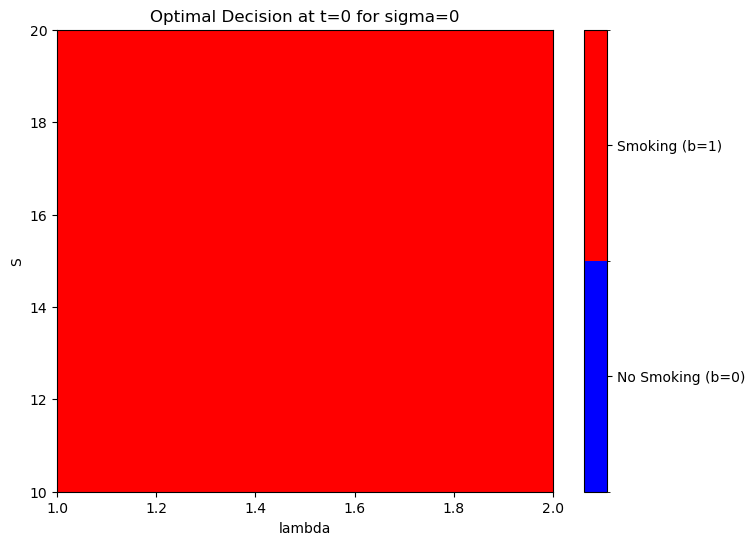

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Assuming Policy, S_grid, lambda_grid, and sigma_values are defined from the previous code.
# Here, t0=0 and we consider sigma=0.
t0 = 1
sigma0_index = 0

# Create a 2D array to store the optimal decision for each (S, lambda) combination.
decision_grid = np.zeros((len(S_grid), len(lambda_grid)))

# Loop over all grid points for S and lambda.
for i, S_val in enumerate(S_grid):
    for k, lambda_val in enumerate(lambda_grid):
        decision_grid[i, k] = Policy[t0, i, sigma0_index, k]

# Define a discrete colormap with two colors.
# For example, blue for b=0 (no smoking) and red for b=1 (smoking).
cmap = ListedColormap(['blue', 'red'])
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)

# Plot the decision grid using a heatmap.
plt.figure(figsize=(8, 6))
img = plt.imshow(decision_grid, extent=[lambda_grid[0], lambda_grid[-1], S_grid[0], S_grid[-1]],
           aspect='auto', origin='lower', cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ticks=[0, 1])
cbar.ax.set_yticklabels(['No Smoking (b=0)', 'Smoking (b=1)'])
plt.xlabel('lambda')
plt.ylabel('S')
plt.title('Optimal Decision at t=0 for sigma=0')
plt.show()
